Generate images for HSQC
Normalize peaks? min-max
size: 128*128*(1 or 2)


In [1]:
# inspecr coordiates 
import os, torch
from scipy.spatial import Delaunay
import cv2
from tqdm import tqdm
import numpy as np

dir = "/workspace/SMILES_dataset/"
splits = ['train']
first_column = []
second_column = []
for split in splits:
    os.makedirs(f"{dir}{split}/HSQC_images/", exist_ok = True)

    
    HSQC_files = list(os.listdir(os.path.join(dir, split, "HSQC")))
    for ite,file in enumerate(tqdm(HSQC_files)):
        coord = torch.load(os.path.join(dir, split, "HSQC", file))
        first_column.append(coord[:,0])
        second_column.append(coord[:,1])
first_column = torch.cat(first_column).flatten()
second_column = torch.cat(second_column).flatten()

100%|██████████| 109694/109694 [00:41<00:00, 2619.62it/s]


(array([1.00000e+01, 6.00000e+00, 1.70000e+01, 1.36000e+02, 2.07000e+02,
        9.70000e+01, 3.67000e+02, 6.87000e+02, 1.13500e+03, 1.41000e+03,
        6.12500e+03, 2.38390e+04, 7.89570e+04, 6.84840e+04, 7.81750e+04,
        1.69272e+05, 1.06439e+05, 1.15835e+05, 1.08711e+05, 9.72460e+04,
        9.32170e+04, 8.17430e+04, 6.32010e+04, 5.07480e+04, 4.15740e+04,
        3.52930e+04, 3.30810e+04, 2.76120e+04, 2.63070e+04, 2.70510e+04,
        3.31780e+04, 4.00670e+04, 4.78590e+04, 6.72100e+04, 7.12730e+04,
        4.55510e+04, 3.54550e+04, 3.04720e+04, 2.60740e+04, 2.38970e+04,
        2.29060e+04, 2.16760e+04, 2.33920e+04, 2.54740e+04, 2.39610e+04,
        2.90790e+04, 1.91230e+04, 1.57740e+04, 1.40840e+04, 1.57770e+04,
        1.39270e+04, 1.77240e+04, 1.74880e+04, 1.73580e+04, 1.84480e+04,
        2.29770e+04, 2.71380e+04, 2.26120e+04, 2.45590e+04, 2.86240e+04,
        2.53770e+04, 1.98420e+04, 1.34800e+04, 8.70500e+03, 7.32700e+03,
        5.91700e+03, 3.79000e+03, 2.49000e+03, 1.77

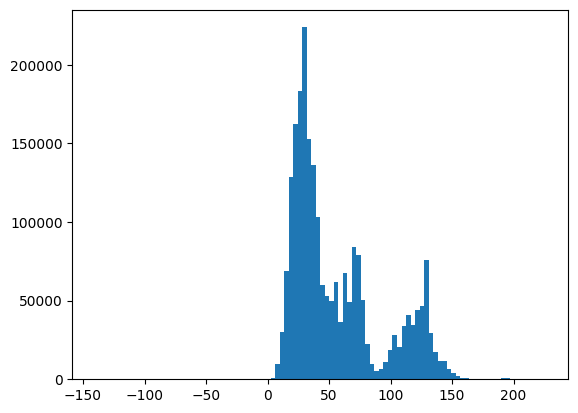

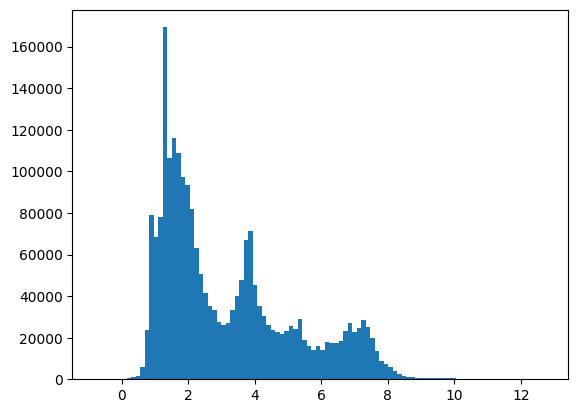

In [2]:
import matplotlib.pyplot as plt
plt.hist(first_column, bins=100)
plt.figure()
plt.hist(second_column, bins=100)

In [3]:
first_column.max(), first_column.min(), second_column.max(), second_column.min()

(tensor(226.2500, dtype=torch.float64),
 tensor(-140.3500, dtype=torch.float64),
 tensor(12.7500, dtype=torch.float64),
 tensor(-0.8067, dtype=torch.float64))

In [25]:
import cv2


dir = "/workspace/SMILES_dataset/"
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(f"{dir}{split}/HSQC_images_1channel/", exist_ok = True)
    os.makedirs(f"{dir}{split}/HSQC_images_2channel/", exist_ok = True)
    
    HSQC_files = list(os.listdir(os.path.join(dir, split, "HSQC")))
    for ite,file in enumerate(tqdm(HSQC_files)):

        coord = torch.load(os.path.join(dir, split, "HSQC", file)).float()
        coord[:,0] = torch.clamp(coord[:,0], 0, 179)
        coord[:,1] = torch.clamp(coord[:,1]*10, 0, 119)  
        coord[:,1] = 119 - coord[:,1]

        #### just one channel (all toghether) ####
        img = torch.zeros((180,120)) 
        img[tuple(torch.round(coord[:,:2]).long().T)] = (coord[:,2]).float()
        if (torch.max(torch.abs(img)) == 0):
            print("up")
            print(img)
            break
        img =  img / torch.max(torch.abs(img))
        
        resized_img = cv2.resize(np.array(img), (128, 128))
        resized_img = torch.tensor(resized_img).unsqueeze(0)

        torch.save(resized_img, f"{dir}{split}/HSQC_images_1channel/{file}")

        #### two channels (pos and neg) ####
        pos = coord[coord[:,2]>0]
        neg = coord[coord[:,2]<0]     
        img_pos = torch.zeros((180,120)) 
        img_neg = torch.zeros((180,120)) 
        img_pos[tuple(torch.round(pos[:,:2]).long().T)] = pos[:,2]
        img_neg[tuple(torch.round(neg[:,:2]).long().T)] = torch.abs(neg[:,2])
        # if torch.max(torch.abs(img_pos)) == 0 or torch.max(torch.abs(img_neg)) == 0:
        #     print(coord)
        #     break
        if torch.max(torch.abs(img_pos)):
            img_pos =  img_pos / torch.max(torch.abs(img_pos))
        if torch.max(torch.abs(img_neg)):
            img_neg =  img_neg / torch.max(torch.abs(img_neg))
        
        resized_pos = cv2.resize(np.array(img_pos), (128, 128))
        resized_pos = torch.tensor(resized_pos).unsqueeze(0)
        resized_neg = cv2.resize(np.array(img_neg), (128, 128))
        resized_neg = torch.tensor(resized_neg).unsqueeze(0)
        resized_img = torch.cat([resized_pos, resized_neg], dim=0)
        
        torch.save(resized_img, f"{dir}{split}/HSQC_images_2channel/{file}")
        # break
        


  0%|          | 0/109694 [00:00<?, ?it/s]

100%|██████████| 13630/13630 [00:35<00:00, 381.25it/s]


In [12]:
img_pos = torch.zeros((180,120)).unsqueeze(0)
img_neg = torch.zeros((180,120)).unsqueeze(0)
torch.cat([img_pos, img_neg], dim=0).shape

torch.Size([2, 180, 120])

In [18]:
m = torch.nn.Dropout(p=0.2)
input = torch.randn(8, 4)
output = m(input)
print(input), print(output)

tensor([[ 0.0703,  0.6091,  0.0908, -0.9574],
        [ 0.9257,  1.0127,  2.2719, -1.5383],
        [-0.7570,  1.1360, -1.6860,  1.6865],
        [ 0.7947,  1.4106,  0.1447, -0.2963],
        [ 0.6804,  0.2875, -0.2854, -1.3025],
        [-0.8224,  0.4980,  0.2263,  0.3144],
        [ 0.1135,  0.5653, -1.3511,  1.3210],
        [-0.0239,  0.3309,  1.8000, -0.7531]])
tensor([[ 0.0879,  0.7614,  0.0000, -1.1967],
        [ 0.0000,  1.2658,  2.8399, -1.9229],
        [-0.9463,  1.4200, -2.1075,  2.1081],
        [ 0.9933,  1.7633,  0.1809, -0.3703],
        [ 0.8504,  0.3594, -0.3568, -1.6281],
        [-1.0280,  0.6225,  0.0000,  0.3930],
        [ 0.1419,  0.7066, -1.6889,  1.6512],
        [-0.0298,  0.4136,  2.2500, -0.9414]])


(None, None)

In [19]:
import torchvision
toy_resnet = torchvision.models.resnet50(pretrained=False)
print(toy_resnet)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 